In [1]:
!pip install albumentations==1.4.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [3]:
import zipfile
import os

zip_path = "/content/parsed_nuclei_dataset.zip"
extract_path = "/content/parsed_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check contents
print("Unzipped folders:", os.listdir(extract_path))


Unzipped folders: ['images', 'masks']


In [4]:
from glob import glob
from sklearn.model_selection import train_test_split

image_paths = sorted(glob("/content/parsed_dataset/images/*.png"))
mask_paths = sorted(glob("/content/parsed_dataset/masks/*.png"))

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


In [5]:
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class NucleiSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

        self.transform = A.Compose([
            A.CLAHE(p=1.0),
            A.GaussianBlur(blur_limit=(3, 5), p=0.5),
            A.Resize(256, 256),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype("float32")

        augmented = self.transform(image=img, mask=mask)
        image = augmented["image"]
        mask = augmented["mask"].unsqueeze(0)

        return image, mask


In [6]:
from torch.utils.data import DataLoader

train_ds = NucleiSegmentationDataset(train_imgs, train_masks)
val_ds = NucleiSegmentationDataset(val_imgs, val_masks)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)


In [7]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(256, 512), CBR(512, 512))

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256))

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128))

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        # Output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [9]:
def train_fn(loader, model, optimizer, loss_fn):
    model.train()
    epoch_loss = 0

    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = (model(imgs) > 0.5).float()

            intersection = (preds * masks).sum(dim=(2, 3))
            union = (preds + masks).sum(dim=(2, 3)) - intersection
            dice = (2. * intersection) / (preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3)) + 1e-8)
            iou = intersection / (union + 1e-8)

            dice_scores.append(dice.mean().item())
            iou_scores.append(iou.mean().item())

    return np.mean(dice_scores), np.mean(iou_scores)


In [11]:
EPOCHS = 100
for epoch in range(EPOCHS):
    loss = train_fn(train_loader, model, optimizer, criterion)
    dice, iou = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f} | Dice: {dice:.4f} | IoU: {iou:.4f}")


Epoch 1/100 - Loss: 0.1473 | Dice: 0.7935 | IoU: 0.6973
Epoch 2/100 - Loss: 0.1452 | Dice: 0.7820 | IoU: 0.6675
Epoch 3/100 - Loss: 0.1234 | Dice: 0.8388 | IoU: 0.7471
Epoch 4/100 - Loss: 0.1087 | Dice: 0.8567 | IoU: 0.7726
Epoch 5/100 - Loss: 0.1055 | Dice: 0.6713 | IoU: 0.5357
Epoch 6/100 - Loss: 0.0962 | Dice: 0.8493 | IoU: 0.7613
Epoch 7/100 - Loss: 0.0965 | Dice: 0.8043 | IoU: 0.6961
Epoch 8/100 - Loss: 0.0924 | Dice: 0.8563 | IoU: 0.7712
Epoch 9/100 - Loss: 0.0856 | Dice: 0.8600 | IoU: 0.7761
Epoch 10/100 - Loss: 0.0828 | Dice: 0.8563 | IoU: 0.7711
Epoch 11/100 - Loss: 0.0849 | Dice: 0.8685 | IoU: 0.7891
Epoch 12/100 - Loss: 0.0869 | Dice: 0.8595 | IoU: 0.7758
Epoch 13/100 - Loss: 0.0872 | Dice: 0.8545 | IoU: 0.7728
Epoch 14/100 - Loss: 0.0912 | Dice: 0.8343 | IoU: 0.7421
Epoch 15/100 - Loss: 0.0852 | Dice: 0.8769 | IoU: 0.8012
Epoch 16/100 - Loss: 0.0803 | Dice: 0.8200 | IoU: 0.7168
Epoch 17/100 - Loss: 0.0833 | Dice: 0.7738 | IoU: 0.6578
Epoch 18/100 - Loss: 0.0907 | Dice: 0.87

In [12]:
import matplotlib.pyplot as plt

def visualize_sample(model, dataset, index=0):
    model.eval()
    image, true_mask = dataset[index]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(image_input).squeeze().cpu().numpy()

    image_np = image.permute(1, 2, 0).numpy()
    true_mask_np = true_mask.squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image_np)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(true_mask_np, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask > 0.5, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


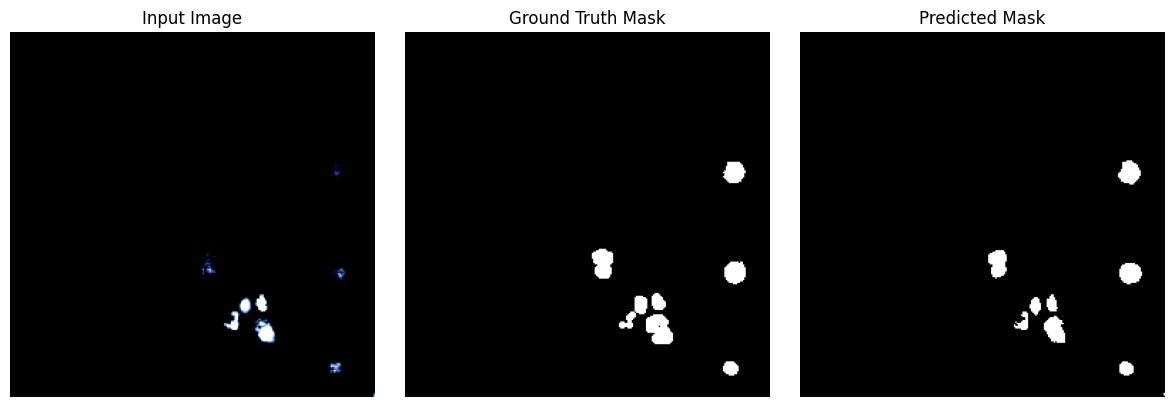

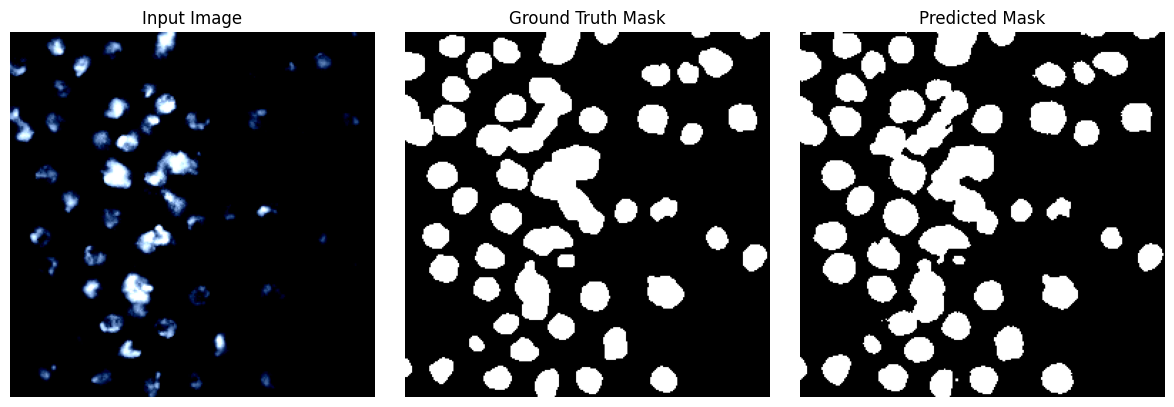

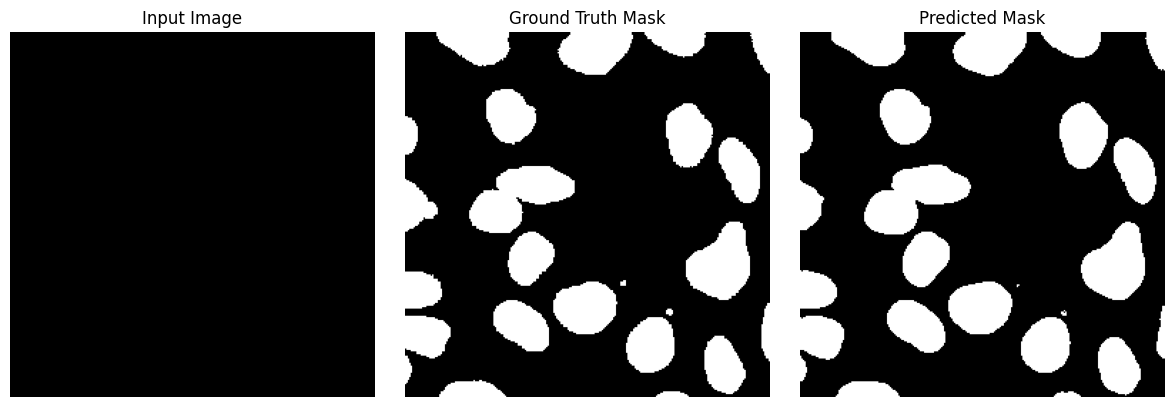

In [13]:
for i in range(3):
    visualize_sample(model, val_ds, index=i)


In [14]:
torch.save(model.state_dict(), "/content/unet_nuclei_model.pth")


In [15]:
import cv2
import os

os.makedirs("/content/predictions", exist_ok=True)

model.eval()
for idx in range(10):
    image, _ = val_ds[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu().numpy()
    binary = (pred > 0.5).astype("uint8") * 255
    cv2.imwrite(f"/content/predictions/pred_mask_{idx:02d}.png", binary)


In [16]:
!zip -r /content/unet_outputs.zip /content/predictions /content/unet_nuclei_model.pth


  adding: content/predictions/ (stored 0%)
  adding: content/predictions/pred_mask_07.png (deflated 21%)
  adding: content/predictions/pred_mask_02.png (deflated 4%)
  adding: content/predictions/pred_mask_04.png (deflated 18%)
  adding: content/predictions/pred_mask_06.png (deflated 31%)
  adding: content/predictions/pred_mask_03.png (deflated 7%)
  adding: content/predictions/pred_mask_01.png (deflated 8%)
  adding: content/predictions/pred_mask_08.png (deflated 4%)
  adding: content/predictions/pred_mask_05.png (deflated 27%)
  adding: content/predictions/pred_mask_09.png (deflated 5%)
  adding: content/predictions/pred_mask_00.png (deflated 31%)
  adding: content/unet_nuclei_model.pth (deflated 7%)
